In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import sys
import json
import gc
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import RobustScaler

warnings.simplefilter('ignore')

In [2]:
basedir = Path().resolve().parent
sys.path.append(str(basedir))

In [3]:
cachedir = basedir / "cache"
logdir = basedir / "logs"
datadir = basedir / "data"
expt = "lstm-soft-fullconnect-dropout"

In [4]:
from src.utils import (
    seed_every_thing,
    fetch_data,
    Config,
    plot_metric,
    reduce_tf_gpu_memory,
    reduce_mem_usage,
    fetch_custom_data,
    CustomL1Loss,
)

In [5]:
cfg_file_path = logdir / expt / "config.json"
with open(cfg_file_path, "rb") as f:
    config = json.load(f)

config = Config().update(config)

In [12]:
def build_model(config: Config, n_features) -> keras.models.Sequential:
    model = keras.models.Sequential([keras.layers.Input(shape=(config.cut, n_features))])
    for n_unit in config.n_units:
        model.add(
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    n_unit,
                    return_sequences=True,
                )
            )
        )
    for n_unit in config.n_dense_units:
        model.add(keras.layers.Dense(n_unit, activation="selu"))
    model.add(keras.layers.Dense(1))
    # model.load_weights(basemodeldir / "weights_custom_best.h5")

    embed = model.layers[-2].output
    embed = keras.layers.Dense(config.embed_dim, activation="selu")(embed)
    concat = keras.layers.Flatten()(embed)
    concat = keras.layers.Dropout(config.dropout)(concat)
    outputs = keras.layers.Dense(config.cut)(concat)

    fc_model = keras.models.Model(inputs=model.inputs, outputs=outputs)
    fc_model.compile(optimizer=keras.optimizers.Adam(learning_rate=config.lr), loss="mae")
    return fc_model

In [7]:
train_df = reduce_mem_usage(pd.read_csv(cachedir / f"train-10fold-cut-soft-rc-2-debugFalse.csv"))
test_df = reduce_mem_usage(pd.read_csv(cachedir / f"test-10fold-cut-soft-rc-2-debugFalse.csv"))

Memory usage of dataframe is 2216.21 MB
Memory usage after optimization is: 543.98 MB
Decreased by 75.5%
Memory usage of dataframe is 1450.61 MB
Memory usage after optimization is: 357.62 MB
Decreased by 75.3%


In [8]:
# train_df = train_df[np.arange(train_df.shape[0]) % 80 < config.cut].reset_index(drop=True)

In [9]:
pressure = train_df.pressure.values.squeeze().reshape(-1,1).astype('float32')
P_MIN = np.min(pressure)
P_MAX = np.max(pressure)
P_STEP = (pressure[1] - pressure[0])[0]
print('Min pressure: {}'.format(P_MIN))
print('Max pressure: {}'.format(P_MAX))
print('Pressure step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(pressure).shape[0]))

del pressure
gc.collect()

Min pressure: -1.8955078125
Max pressure: 64.8125
Pressure step: 0.0703125
Unique values:  950


0

In [10]:
kfolds = train_df.iloc[0::config.cut]['kfold'].values

# ignore_features = [c for c in train_df.columns if "neib" in c]
# features = list(train_df.drop(["kfold", "pressure"] + ignore_features, axis=1).columns)
features = list(train_df.drop(["kfold", "pressure"], axis=1).columns)

cont_features = [f for f in features if ("RC_" not in f) and ("R_" not in f) and ("C_" not in f) and ("u_out" not in f)]

RS = RobustScaler()
train_df[cont_features] = RS.fit_transform(train_df[cont_features])
test_df[cont_features] = RS.transform(test_df[cont_features])
train_data, test_data = train_df[features].values, test_df[features].values

train_data = train_data.reshape(-1, config.cut, train_data.shape[-1])
targets = train_df[["pressure"]].to_numpy().reshape(-1, config.cut)
test_data = test_data.reshape(-1, config.cut, test_data.shape[-1])

In [13]:
with tf.device(f"/GPU:{2}"):
    test_preds = []
    for fold in range(config.n_splits):
        print("-" * 15, ">", f"Fold {fold+1}", "<", "-" * 15)
        savedir = logdir / expt / f"fold{fold}"
        model = build_model(config=config, n_features=len(features))
        model.load_weights(savedir / "weights_custom_best.h5")
        
        test_preds.append(model.predict(test_data).squeeze().reshape(-1, 1).squeeze())

        del model
        keras.backend.clear_session()
        gc.collect()

--------------- > Fold 1 < ---------------


2021-11-03 11:49:38.739458: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-03 11:49:40.937755: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202


--------------- > Fold 2 < ---------------
--------------- > Fold 3 < ---------------
--------------- > Fold 4 < ---------------
--------------- > Fold 5 < ---------------
--------------- > Fold 6 < ---------------
--------------- > Fold 7 < ---------------
--------------- > Fold 8 < ---------------
--------------- > Fold 9 < ---------------
--------------- > Fold 10 < ---------------


In [14]:
# mask = (np.arange(test_preds[0].shape[0]) % 80) < 35
# for i in range(len(test_preds)):
#     test_preds[i] = test_preds[i][mask]

In [15]:
for i in range(len(test_preds)):
    test_preds[i] = np.round((test_preds[i] - P_MIN) / P_STEP) * P_STEP + P_MIN
    test_preds[i] = np.clip(test_preds[i], P_MIN, P_MAX)

In [16]:
preds = np.vstack(test_preds)
preds_std = np.std(preds, axis=0)

0.07572888


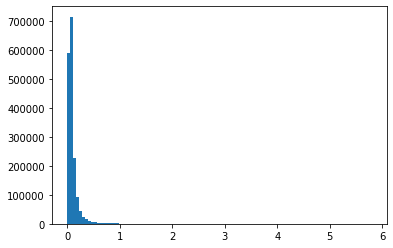

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(preds_std, bins=100)
print(np.median(preds_std))
plt.show()

In [18]:
test_preds_median = np.median(preds, axis=0)
test_preds_mean = np.mean(preds, axis=0)

In [19]:
thresh = 0.06
preds_custom = np.where(preds_std <= thresh, test_preds_mean, test_preds_median)

In [20]:
preds_custom = np.round((preds_custom - P_MIN) / P_STEP) * P_STEP + P_MIN
preds_custom = np.clip(preds_custom, P_MIN, P_MAX)

In [21]:
submission = pd.read_csv(datadir / "sample_submission.csv")
counts = np.arange(submission.shape[0]) % 80
submission.loc[counts < 35, "pressure"] = preds_custom
submission.to_csv(logdir / expt / "custom_submission.csv", index=False)
submission.head()

,id,pressure
0,1,6.260742
1,2,5.979492
2,3,7.104492
3,4,7.666992
4,5,9.143555
